In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import pylab
import matplotlib.pyplot as plt
from collections import Counter
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import os

from ete3 import Tree

import pickle as pic

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.stats.multitest as multi

import scipy.stats as scs

from tqdm import tqdm_notebook, tqdm


from utilities import de_utils

import gseapy

/home/eecs/mattjones/.local/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


## Read in 10X data matrix & pre-process data

In [2]:
path = "/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/GRCh38/"
# path = '/data/yosef2/users/mattjones/projects/metastasis/100k/RNA/hg19/'
adata = sc.read(path + "matrix.mtx", cache=True).T
genes = pd.read_csv(path + "genes.tsv", header=None, sep='\t')
adata.var_names = genes[1]
adata.var['gene_ids'] = genes[0]  # add the gene ids as annotation of the variables/genes
adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
adata.var_names_make_unique()

all_genes = adata.var_names

meta = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/LG_meta.txt", sep='\t', index_col=0)
latent = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/latent.csv", sep='\t', index_col = 0)
#meta = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/100k/100k_meta.txt", sep='\t', index_col = 0)
#latent = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/100k/RNA/latent.csv", sep='\t', index_col = 0)
latent.index = adata.obs_names

gene_list = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/filtered_genes.txt", sep='\t', header=None).iloc[:,0].values
#gene_list = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/100k/RNA/filtered_genes.txt", sep='\t', header=None).iloc[:,0].values
adata.shape, latent.shape, meta.shape 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


((43423, 33694), (43423, 10), (40969, 8))

In [3]:
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
adata.obs['percent_mito'] = np.sum(adata[:,mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['nUMI'] = adata.X.sum(axis=1).A1
adata.obs['n_genes'] = np.sum(adata.X > 0, axis=1).A1

adata.obs = adata.obs.merge(meta, left_index = True, right_index=True, how="left")


In [4]:
meta_filter = np.logical_not(adata.obs["DynamicMetScore"].isna())
adata = adata[meta_filter, :]

latent = latent.loc[adata.obs_names].values

In [5]:
scale_factor = np.median(np.array(adata.X.sum(axis=1)))
sc.pp.normalize_per_cell(adata, counts_per_cell_after = scale_factor)

Trying to set attribute `.obs` of view, making a copy.


In [6]:
adata = adata[adata.obs.percent_mito < 0.05, :]

In [41]:
# filter out genes not expressed in at least 1% of cells
thresh = 0.01*adata.shape[0]

sc.pp.filter_genes(adata, min_cells=thresh)

Trying to set attribute `.var` of view, making a copy.


In [42]:
adata.raw = sc.pp.log1p(adata, copy=True)

In [7]:
filter_result = list(map(lambda x: x in gene_list, adata.var_names))
# sc.pl.filter_genes_dispersion(filter_result)
adata = adata[:, filter_result]

In [8]:
sc.pp.log1p(adata)

/home/eecs/mattjones/.local/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:285: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


## Perform dimensionality reduction & visualization

In [310]:
# sc.tl.pca(adata, n_comps=30)

adata.obsm["X_pca"] = latent

In [90]:
sc.tl.tsne(adata, random_state=2, n_pcs=10, n_jobs = 10)

In [91]:
sc.pp.neighbors(adata, n_neighbors = int(np.sqrt(adata.X.shape[0])))
sc.tl.umap(adata)

In [92]:
sc.tl.louvain(adata)

... storing 'sampleID' as categorical
... storing 'gene_ids' as categorical
/home/eecs/mattjones/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/eecs/mattjones/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/eecs/mattjones/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures creat

<Figure size 504x504 with 0 Axes>

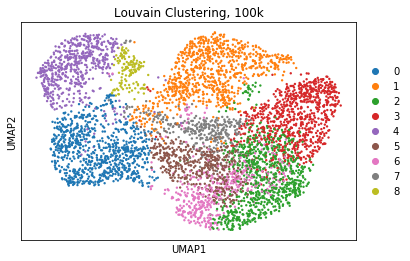

<Figure size 504x504 with 0 Axes>

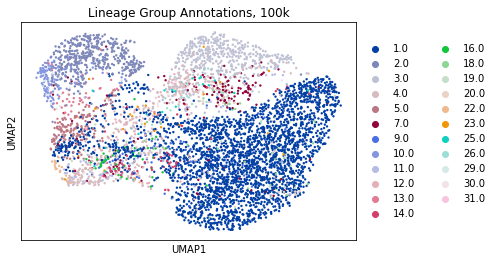

<Figure size 504x504 with 0 Axes>

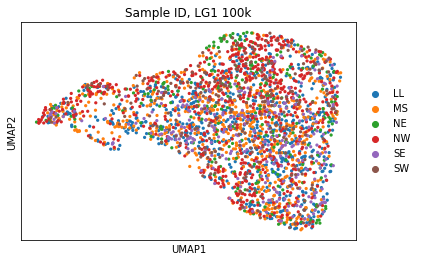

<Figure size 504x504 with 0 Axes>

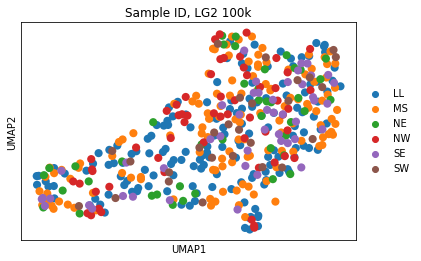

<Figure size 504x504 with 0 Axes>

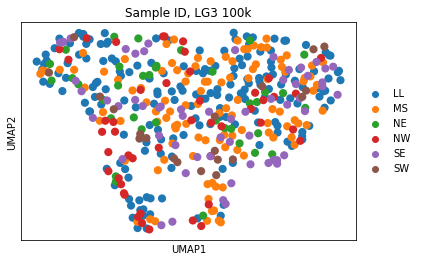

<Figure size 504x504 with 0 Axes>

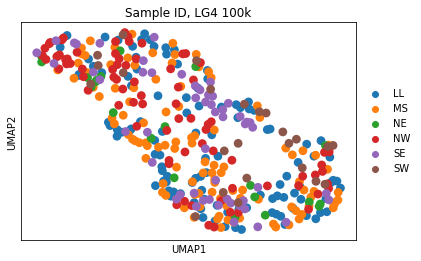

<Figure size 504x504 with 0 Axes>

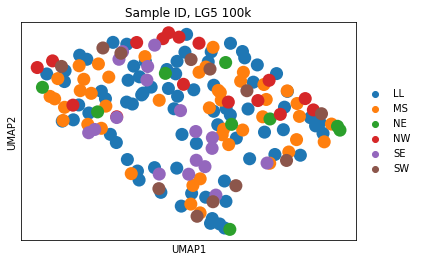

<Figure size 504x504 with 0 Axes>

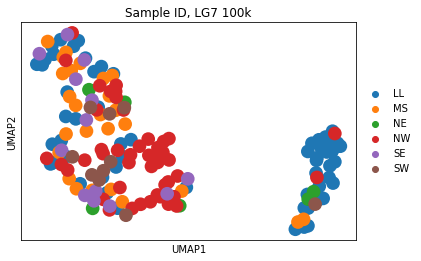

<Figure size 504x504 with 0 Axes>

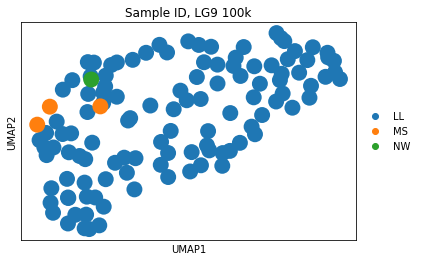

<Figure size 504x504 with 0 Axes>

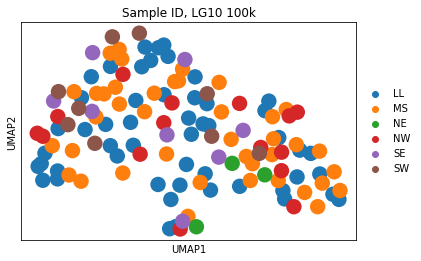

<Figure size 504x504 with 0 Axes>

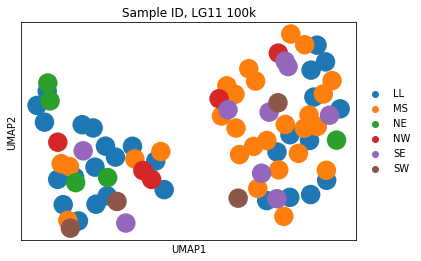

<Figure size 504x504 with 0 Axes>

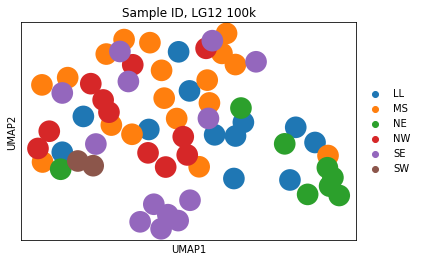

<Figure size 504x504 with 0 Axes>

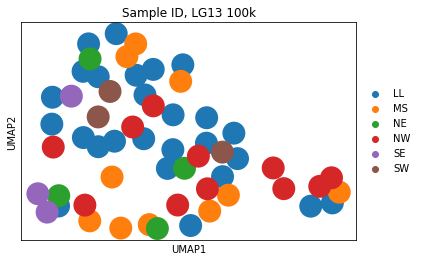

<Figure size 504x504 with 0 Axes>

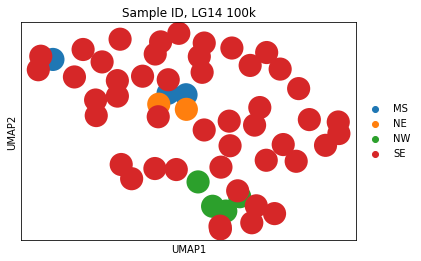

<Figure size 504x504 with 0 Axes>

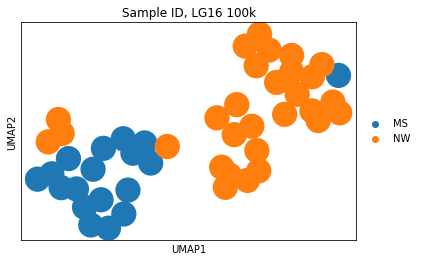

<Figure size 504x504 with 0 Axes>

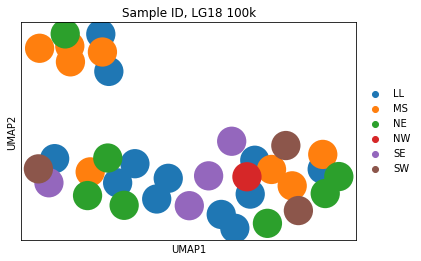

<Figure size 504x504 with 0 Axes>

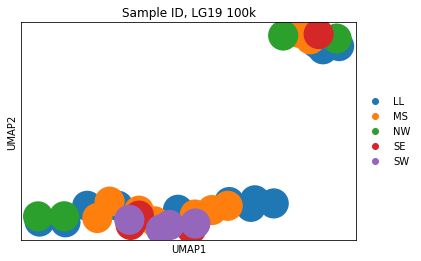

<Figure size 504x504 with 0 Axes>

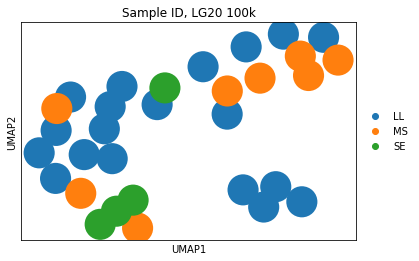

In [93]:
# h = plt.figure(figsize=(7,7))
# ax = sc.pl.umap(adata, color='Sample2', show=False)
# plt.title("Bulk Sample Labels, 100k")
# plt.savefig("figs/umap_sample2.100k.png", bbox_inches='tight')

h = plt.figure(figsize = (7,7))
ax = sc.pl.umap(adata, color = "louvain", show = False)
plt.title("Louvain Clustering, 100k")
plt.savefig("figs/umap_louvain.100k.png", bbox_inches='tight')


adata.obs['LineageGroup'] = adata.obs['LineageGroup'].astype('category')
h = plt.figure(figsize = (7,7))
ax = sc.pl.umap(adata, color = "LineageGroup", show = False)
plt.title("Lineage Group Annotations, 100k")
plt.savefig("figs/umap_lg.100k.png", bbox_inches='tight')


for target_lg in range(1,21):
    if target_lg not in adata.obs['LineageGroup'].unique():
        continue
    lgdata = adata[adata.obs['LineageGroup'] == target_lg]
    sc.pp.neighbors(lgdata, n_neighbors = int(np.sqrt(lgdata.X.shape[0])))
    sc.tl.umap(lgdata)
    #adata.obs['targetLG'] = adata.obs.apply(lambda x: "True" if x.LineageGroup == target_lg else "False", axis=1).astype("category")
    h = plt.figure(figsize = (7,7))
    ax = sc.pl.umap(lgdata, color = "sampleID", show = False)
    plt.title("Sample ID, LG" + str(target_lg) + " 100k")
    plt.savefig("figs/umap_lg" + str(target_lg) + ".100k.png", bbox_inches='tight')


## Get Correlates of Metastatic Ability

In [28]:
#met_scores = pd.read_csv("data/lg_metastatic_scoresAllele.5k.txt", sep='\t', index_col = 0)
met_scores = pd.read_csv("data/lg_metastatic_scoresAllele.5k.txt", sep='\t', index_col = 0)
sig_scores = pd.read_csv("../JQ19/5k/RNA/JQ19.sigscores.txt", sep='\t', index_col = 0)

In [ ]:
sig_scores.index[:10]

In [29]:
keep_cells = np.intersect1d(sig_scores.index, adata.obs_names)
keep_cells = np.intersect1d(keep_cells, adata.obs.index)

meta_filter = list(map(lambda x: x in keep_cells, adata.obs.index.values))
adata = adata[meta_filter, :]

sig_scores_subset = sig_scores.loc[keep_cells]

In [30]:
sig_scores_subset.shape

(34579, 3752)

# Look at single-cell correlates

In [31]:
corrs = {}
signif_sigs = {}

for sig in tqdm(sig_scores_subset.columns):
    
    pcorr = scs.pearsonr(sig_scores_subset.loc[adata.obs.index, sig], adata.obs['DynamicMetScore'])[0]
    scorr = scs.spearmanr(sig_scores_subset[sig], adata.obs['DynamicMetScore'])[0]
    if abs(scorr) > 0.4:
        print(sig, pcorr, scorr)
        signif_sigs[sig] = (pcorr, scorr)
    corrs[sig] = (pcorr, scorr)
        

NameError: name 'sig_scores_subset' is not defined

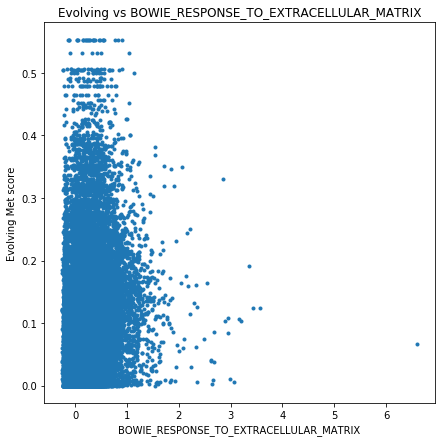

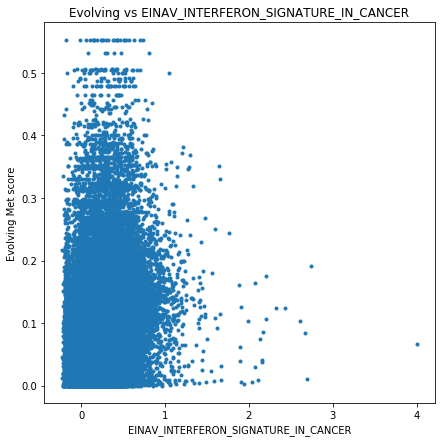

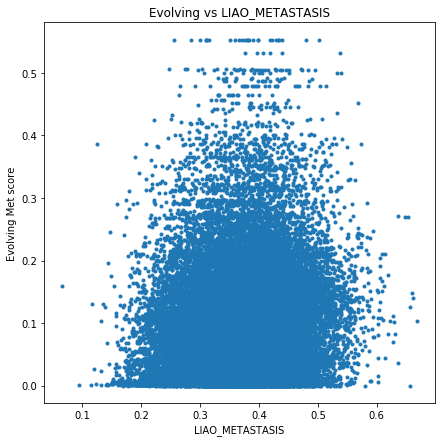

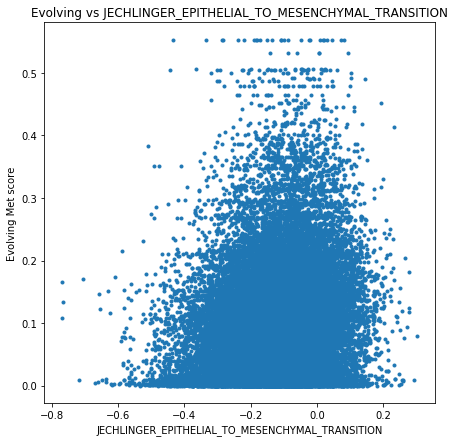

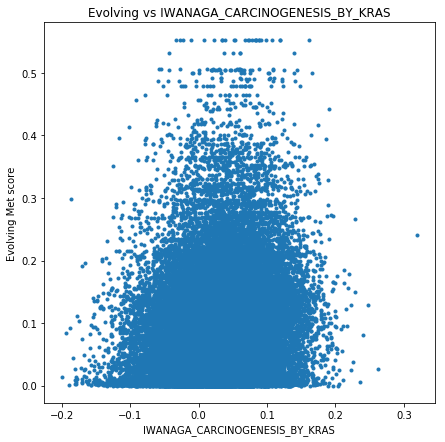

In [26]:
for sig in ["BOWIE_RESPONSE_TO_EXTRACELLULAR_MATRIX", "EINAV_INTERFERON_SIGNATURE_IN_CANCER", "LIAO_METASTASIS", "JECHLINGER_EPITHELIAL_TO_MESENCHYMAL_TRANSITION", "IWANAGA_CARCINOGENESIS_BY_KRAS"]:
    h = plt.figure(figsize = (7,7))
    plt.plot(sig_scores_subset.loc[adata.obs.index, sig], adata.obs['DynamicMetScore'], ".")
    plt.title("Evolving vs " + sig)
    plt.xlabel(sig)
    plt.ylabel("Evolving Met score")
    # plt.savefig('figs/100k/' + sig + "_evomet_corr.100k.pdf")

In [51]:
def run_lin_reg_ALL_GENES(adata, meta_scores, lg):

    pvals = {}
    betas = {}
    corrs = {}
    scorrs = {}

    # meta_scores = -np.log10(adata.obs[meta_var]+0.001)

    for gene in tqdm(adata.var_names):
        #ex = adata.X[:,(adata.var_names == gene)][:,0].toarray()[:,0].reshape(adata.shape[0], 1)
        # ex = np.concatenate((X, lg.values.reshape(adata.shape[0], 1)), 1)
        #reg = LinearRegression().fit(ex, y)
        
        #slope, intercept, r_value, p_value = reg.coef_[0], reg.intercept_, reg.score(), reg.score()
        ex = adata.X[:,(adata.var_names == gene)][:,0].toarray()[:,0]
        slope, intercept, r_value, p_value, std_err = scs.linregress(ex, meta_scores)
        
        pvals[gene] = p_value
        betas[gene] = slope
        corrs[gene] = r_value

        # scorrs[gene] = scs.spearmanr(ex, meta_scores)[0]

    return pvals, betas, corrs, scorrs

adata_1 = adata[adata.obs.apply(lambda x: x.LineageGroup == 1, axis=1),:]
all_pvalues, all_betas, all_corr, all_scorr = run_lin_reg_ALL_GENES(adata_1, adata_1.obs['DynamicMetScore'], adata_1.obs['LineageGroup'])

genedf = pd.DataFrame.from_dict(all_pvalues, orient="index", columns=['pvalues'])
genedf["betas"] = list(map(lambda x: all_betas[x], all_pvalues.keys()))
genedf["Corr"] = list(map(lambda x: all_corr[x], all_pvalues.keys()))
# genedf["SpearmanCorr"] = list(map(lambda x: all_scorr[x], all_pvalues.keys()))
genedf["Adjusted P-values"] = multi.multipletests(genedf["pvalues"], alpha=0.05, method='fdr_bh')[1]

genedf.sort_values(by="Adjusted P-values", ascending=True).head()


  3%|▎         | 119/4005 [00:01<01:01, 63.10it/s]/home/eecs/mattjones/.local/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:116: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/eecs/mattjones/.local/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:128: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)

100%|██████████| 4005/4005 [01:05<00:00, 61.11it/s]

,pvalues,betas,Corr,Adjusted P-values
RPS27,2.646022e-73,-0.038425,-0.175092,1.059732e-69
TMSB4X,2.710794e-57,0.025707,0.154504,5.428365e-54
MT-CO3,1.756253e-54,0.019161,0.150585,2.344597e-51
MT-CO1,2.985482e-49,0.017942,0.142997,2.989214e-46
CXCL8,5.839720e-47,-0.012415,-0.139538,4.677616e-44


In [36]:
# genedf.to_csv("data/evolving_score_prediction.5k.single_cell.txt", sep='\t')

In [54]:
print(genedf.shape)
genedf['log10qval'] = -np.log10(genedf['Adjusted P-values'])

print(genedf.loc['B2M'])

# genedf['log10qval'] = np.nan_to_num(genedf['log10qval'])
genedf.sort_values(by = 'Corr', ascending = False)
# genedf.sort_values(by="Adjusted P-values", ascending=True).head()

(4005, 5)
pvalues              8.690575e-26
betas                1.398842e-02
Corr                 1.020338e-01
Adjusted P-values    9.668264e-24
log10qval            2.301465e+01
Name: B2M, dtype: float64


,pvalues,betas,Corr,Adjusted P-values,log10qval
TMSB4X,2.710794e-57,0.025707,0.154504,5.428365e-54,53.265331
MT-CO3,1.756253e-54,0.019161,0.150585,2.344597e-51,50.629932
MT-CO1,2.985482e-49,0.017942,0.142997,2.989214e-46,45.524443
MT-CO2,4.354500e-45,0.016537,0.136644,2.906629e-42,41.536610
SEPW1,1.098402e-44,0.019464,0.136015,6.284427e-42,41.201734
LGALS1,4.603043e-41,0.015516,0.130203,2.304399e-38,37.637442
CLU,1.777028e-40,0.017664,0.129236,7.907776e-38,37.101946
SERF2,1.794738e-39,0.026242,0.127564,7.187926e-37,36.143396
NEAT1,1.683804e-37,0.016062,0.124213,5.187410e-35,34.285049
AGR2,1.558213e-36,0.012082,0.122537,4.457602e-34,33.350899


/home/eecs/mattjones/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


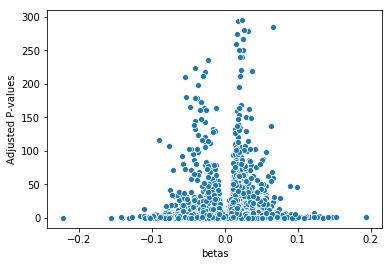

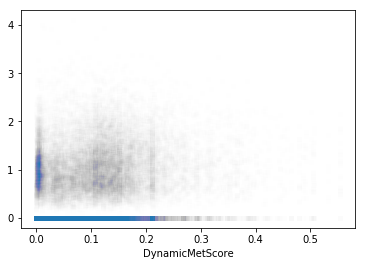

,pvalues,betas,Corr,SpearmanCorr,Adjusted P-values,log10qval
LGALS1,0.000000e+00,0.027764,0.265585,0.298641,0.000000e+00,1.797693e+308
MT-CO2,0.000000e+00,0.024376,0.233530,0.287641,0.000000e+00,1.797693e+308
REG4,0.000000e+00,0.029592,0.218988,0.278291,0.000000e+00,1.797693e+308
MT-CO1,0.000000e+00,0.025334,0.234293,0.275205,0.000000e+00,1.797693e+308
DPYSL3,0.000000e+00,0.059764,0.236889,0.275097,0.000000e+00,1.797693e+308
B2M,0.000000e+00,0.029046,0.232387,0.265623,0.000000e+00,1.797693e+308
S100A4,0.000000e+00,0.037925,0.237497,0.257700,0.000000e+00,1.797693e+308
SEPW1,0.000000e+00,0.030026,0.234167,0.257548,0.000000e+00,1.797693e+308
IFI27,0.000000e+00,0.030972,0.218269,0.252053,0.000000e+00,1.797693e+308
SH3BGRL3,0.000000e+00,0.026733,0.215691,0.243088,0.000000e+00,1.797693e+308


In [16]:
sns.scatterplot(genedf['betas'], -np.log10(genedf['Adjusted P-values']))
plt.show()

ex = adata.X[:,(adata.var_names == 'IFI6')][:,0].toarray()[:,0]
sns.scatterplot(adata.obs['DynamicMetScore'], ex, alpha=0.005)
plt.show()

genedf.sort_values(by = 'SpearmanCorr', ascending = False)

# Look at bulk correlates

In [31]:
for sig in tqdm(sig_scores_subset.columns):
    met_scores[sig] = 0
    for lg, g in adata.obs.groupby("LineageGroup"):
        if int(lg) not in met_scores.index:
            continue
        cells = g.index.values
        met_scores.loc[lg, sig] = np.mean(sig_scores_subset.loc[cells, sig])

100%|██████████| 3752/3752 [10:25<00:00,  6.49it/s]


In [35]:
corrs = []
ks_stats = []

signif_sigs = {}
for sig in tqdm(sig_scores_subset.columns):
    
    pcorr = scs.pearsonr(met_scores[sig], met_scores["Dynamic"])[0]  
    scorr = scs.spearmanr(met_scores[sig], met_scores['Dynamic'])[0]
    #ks = scs.ks_2samp(met_scores[sig], met_scores["Evolving"])[0]
    if abs(scorr) > 0.4:
        print(sig, pcorr, scorr)
        signif_sigs[sig] = scorr
    corrs.append(scorr)

 14%|█▍        | 530/3752 [00:00<00:04, 740.96it/s]

PID_REG_GR_PATHWAY -0.44620207797744177 -0.4344325287646768


 42%|████▏     | 1565/3752 [00:02<00:02, 792.83it/s]

BUSA_SAM68_TARGETS -0.4512119961901933 -0.40098476199625027


 46%|████▌     | 1725/3752 [00:02<00:02, 785.84it/s]

FARMER_BREAST_CANCER_CLUSTER_1 0.45651567092108 0.46983299001487594


 48%|████▊     | 1804/3752 [00:02<00:02, 775.64it/s]

BOWIE_RESPONSE_TO_TAMOXIFEN 0.35115701208246936 0.40053333262680824
XU_AKT1_TARGETS_48HR 0.39379876154057236 0.42140406719543094
DAUER_STAT3_TARGETS -0.48839972870743426 -0.4175826650913169


 52%|█████▏    | 1962/3752 [00:02<00:02, 763.12it/s]

GROSS_HYPOXIA_VIA_ELK3 0.45376730413476757 0.4088585300679138


 59%|█████▊    | 2199/3752 [00:02<00:01, 777.58it/s]

JECHLINGER_EPITHELIAL_TO_MESENCHYMAL_TRANSITION 0.4617223495875746 0.43452701398153676
NING_CHRONIC_OBSTRUCTIVE_PULMONARY_DISEASE -0.40009740676087147 -0.43584980701757625


 63%|██████▎   | 2346/3752 [00:03<00:02, 618.17it/s]

TAVOR_CEBPA_TARGETS -0.5180860346553305 -0.5212014529144088


 65%|██████▍   | 2422/3752 [00:03<00:02, 653.13it/s]

MARCHINI_TRABECTEDIN_RESISTANCE 0.45292122991927547 0.40620244563840596


 73%|███████▎  | 2729/3752 [00:03<00:01, 738.57it/s]

TESAR_JAK_TARGETS_MOUSE_ES_D3 -0.4182347660864409 -0.43846389801736857
MARTINEZ_TP53_TARGETS 0.4398780171328861 0.47615300118706455
MARTINEZ_RB1_AND_TP53_TARGETS 0.47182376745583904 0.48046782609033617


 75%|███████▍  | 2804/3752 [00:03<00:01, 716.80it/s]

MOSERLE_IFNA_RESPONSE 0.4870878114626994 0.4765834338416488


 77%|███████▋  | 2877/3752 [00:03<00:01, 714.94it/s]

EHLERS_ANEUPLOIDY -0.3690485434852206 -0.4177506388101791


 83%|████████▎ | 3114/3752 [00:04<00:00, 764.04it/s]

CHIANG_LIVER_CANCER_SUBCLASS_INTERFERON 0.4088467942599786 0.4335926601703661
YOSHIOKA_LIVER_CANCER_EARLY_RECURRENCE -0.46211263719607926 -0.43659519039502703


 92%|█████████▏| 3443/3752 [00:04<00:00, 807.58it/s]

WANG_TNF_TARGETS -0.43171072798585036 -0.4028429712611628


 94%|█████████▍| 3525/3752 [00:04<00:00, 805.73it/s]

PLASARI_TGFB1_TARGETS_10HR -0.38422036095049095 -0.4240286565526521
BOSCO_INTERFERON_INDUCED_ANTIVIRAL_MODULE 0.3769858201226768 0.4848141460658944


 96%|█████████▌| 3606/3752 [00:04<00:00, 796.80it/s]

ANASTASSIOU_MULTICANCER_INVASIVENESS_SIGNATURE 0.5019033944282668 0.4739063526972832
HECKER_IFNB1_TARGETS 0.10745284173641238 0.4106957426179686


 98%|█████████▊| 3686/3752 [00:04<00:00, 792.38it/s]

IL15_UP.V1 -0.39532928309237764 -0.41256445024031


100%|██████████| 3752/3752 [00:04<00:00, 758.37it/s]


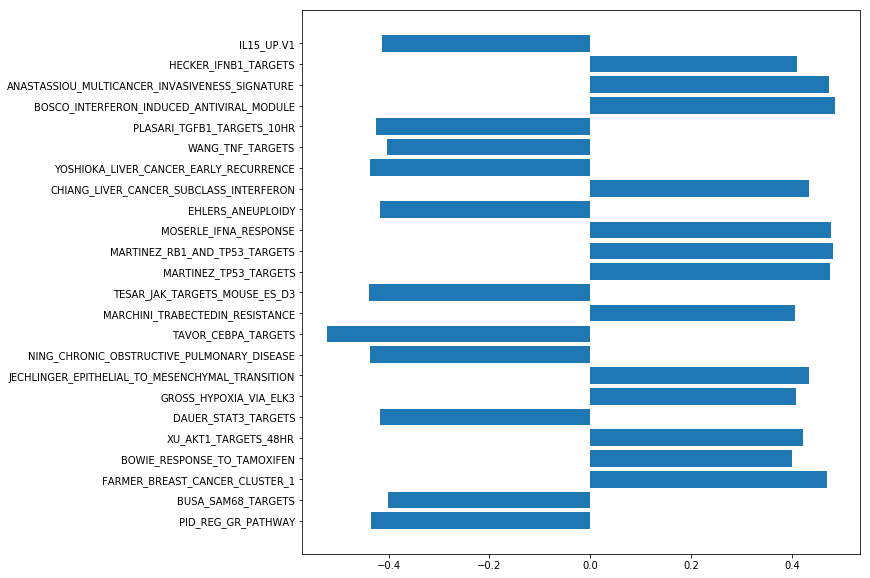

In [36]:
sig_df = pd.DataFrame.from_dict(signif_sigs, orient='index', columns=['PCorr'])
sig_df['signature'] = sig_df.index
sig_df['sign'] = sig_df.apply(lambda x: 'neg' if x.PCorr < 0 else 'pos', axis=1)

# print(sig_df.sort_values(by='PCorr'))

h = plt.figure(figsize = (10, 10))
plt.barh(sig_df.index, sig_df['PCorr'])
# plt.savefig('figs/100k/correlated_signatures.100k.pdf', bbox_inches='tight')
plt.show()

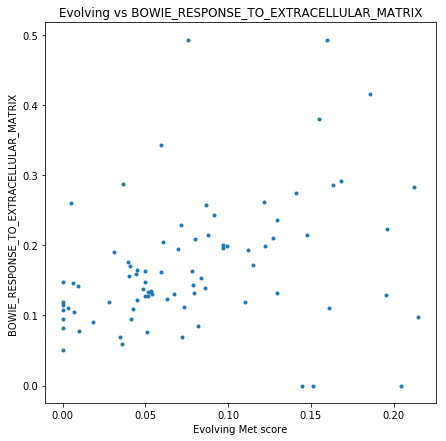

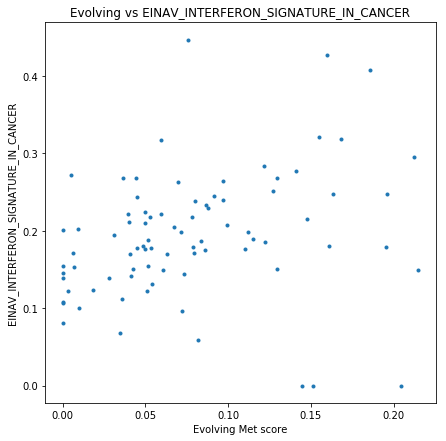

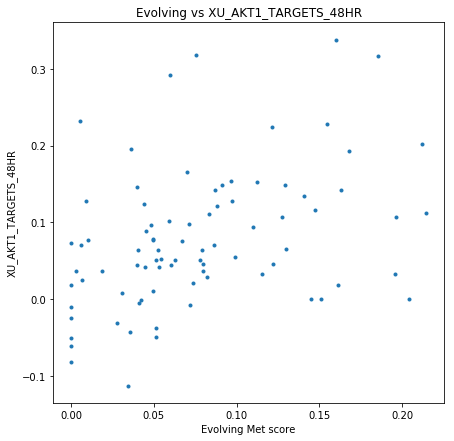

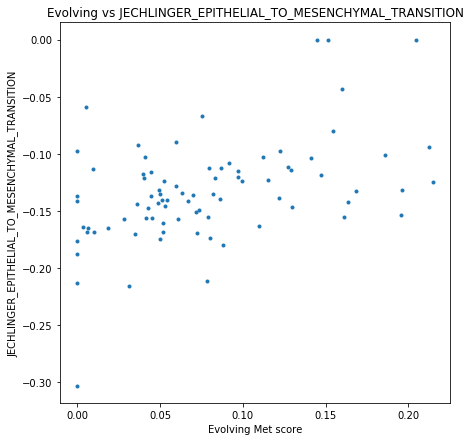

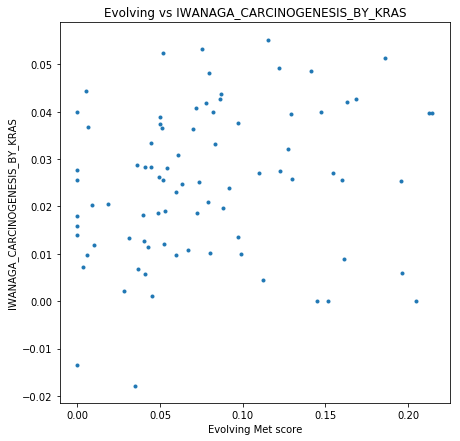

In [37]:
for sig in ["BOWIE_RESPONSE_TO_EXTRACELLULAR_MATRIX", "EINAV_INTERFERON_SIGNATURE_IN_CANCER", "XU_AKT1_TARGETS_48HR", "JECHLINGER_EPITHELIAL_TO_MESENCHYMAL_TRANSITION", "IWANAGA_CARCINOGENESIS_BY_KRAS"]:
    h = plt.figure(figsize = (7,7))
    plt.plot(met_scores["Dynamic"],met_scores[sig], ".")
    plt.title("Evolving vs " + sig)
    plt.ylabel(sig)
    plt.xlabel("Evolving Met score")
    # plt.savefig('figs/100k/' + sig + "_evomet_corr.100k.pdf")

### Run genewise analysis with pseudobulk 

In [374]:
lg_groups = {}
for n, g in adata.obs.groupby("LineageGroup"):
    lg_groups[int(n)] = g.index
    
agg_counts = np.zeros((adata.X.shape[1], len(adata.obs['LineageGroup'].unique())))
for i, j in tqdm(zip(range(len(lg_groups.keys())), lg_groups.keys()), desc="pooling cells"):

    lg = lg_groups[j]
    filt = list(map(lambda x: x in lg, adata.obs_names))
    if adata[filt,:].shape[0] == 0: 
        lg_counts = np.zeros((adata.X.shape[1],))
    else:
        lg_counts = np.mean(adata[filt,:].X, axis=0)
    
    agg_counts[:,i] = lg_counts
    
lg_adata = sc.AnnData(agg_counts.T)
lg_adata.obs_names = list(lg_groups.keys())
lg_adata.var_names = adata.var_names
lg_adata.obs["dynamic"] = met_scores.loc[lg_adata.obs_names, "Dynamic"]
lg_adata.obs["static"] = met_scores.loc[lg_adata.obs_names, "Static"]

meta_filter = np.logical_not(lg_adata.obs["dynamic"].isna())
lg_adata = lg_adata[meta_filter,:]
lg_adata.obs.shape

pooling cells: 19it [00:00, 24.06it/s]
AnnData expects string indices for some functionality, but your first two indices are: [1, 2]. 


(19, 2)

In [375]:
hallmark_sigs = gseapy.parser.gsea_gmt_parser("/data/yosef2/users/mattjones/data/h.all.v5.2.symbols.gmt")
c2_sigs = gseapy.parser.gsea_gmt_parser("/data/yosef2/users/mattjones/data/c2.all.v6.0.symbols.gmt")
c6_sigs = gseapy.parser.gsea_gmt_parser("/data/yosef2/users/mattjones/data/c6.all.v6.0.symbols.gmt")

all_sigs = {**hallmark_sigs, **c2_sigs, **c6_sigs}

In [376]:
gene_counter = {}
for sig in tqdm(signif_sigs, desc="trying significant signatures"):
    
    if sig not in all_sigs:
        up_sig, dn_sig = sig + "_UP", sig + "_DN"
        if up_sig in all_sigs:
            res, up_genes = de_utils.run_lin_reg(lg_adata, all_sigs[up_sig], 'dynamic')
        if dn_sig in all_sigs:
            res, down_genes = de_utils.run_lin_reg(lg_adata, all_sigs[dn_sig], 'dynamic')
        
        genes = up_genes + down_genes
    else:
        res, genes = de_utils.run_lin_reg(lg_adata, all_sigs[sig], 'dynamic')

    for g in genes:
        if g not in gene_counter:
            gene_counter[g] = 0
        gene_counter[g] += 1
        
df = pd.DataFrame.from_dict(gene_counter, orient="index")

trying significant signatures:   0%|          | 0/37 [00:00<?, ?it/s]/home/eecs/mattjones/.local/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:116: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/eecs/mattjones/.local/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:128: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
trying significant signatures: 100%|██████████| 37/37 [00:00<00:00, 49.61it/s]


<Figure size 864x864 with 0 Axes>

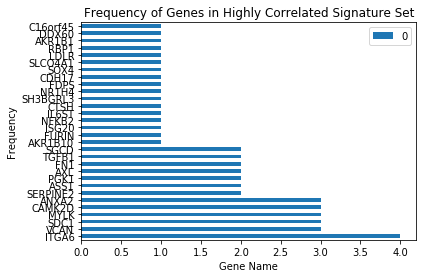

<Figure size 432x288 with 0 Axes>

In [381]:
h = plt.figure(figsize=(12,12))
df.sort_values(by=0, ascending=False).head(30).plot(kind='barh')
plt.title("Frequency of Genes in Highly Correlated Signature Set")
plt.xlabel("Gene Name")
plt.ylabel("Frequency")
plt.show()
plt.savefig("figs/100k/gene_freq_corrsigs.100k.pdf", bbox_inches='tight')

In [382]:
def run_lin_reg_ALL_GENES(adata, meta_var):

    pvals = {}
    betas = {}
    corrs = {}
    scorrs = {}

    meta_scores = adata.obs[meta_var]

    for gene in tqdm(adata.var_names):
        ex = adata.X[:,(adata.var_names == gene)][:,0]
        slope, intercept, r_value, p_value, std_err = scs.linregress(meta_scores, ex)

        pvals[gene] = p_value
        betas[gene] = slope
        corrs[gene] = r_value

        scorrs[gene] = scs.spearmanr(meta_scores, ex)[0]

    return pvals, betas, corrs, scorrs

In [383]:
all_pvalues, all_betas, all_corr, all_scorr = run_lin_reg_ALL_GENES(lg_adata, 'dynamic')

genedf = pd.DataFrame.from_dict(all_pvalues, orient="index", columns=['pvalues'])
genedf["betas"] = list(map(lambda x: all_betas[x], all_pvalues.keys()))
genedf["Corr"] = list(map(lambda x: all_corr[x], all_pvalues.keys()))
genedf["SpearmanCorr"] = list(map(lambda x: all_scorr[x], all_pvalues.keys()))
genedf["Adjusted P-values"] = multi.multipletests(genedf["pvalues"], alpha=0.05, method='fdr_bh')[1]

genedf.sort_values(by="Adjusted P-values", ascending=True).head()

genedf.to_csv("figs/100k/evolving_score_prediction.100k.txt", sep='\t')

  0%|          | 0/4275 [00:00<?, ?it/s]/home/eecs/mattjones/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/eecs/mattjones/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/eecs/mattjones/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/eecs/mattjones/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/eecs/mattjones/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
100%|██████████| 4275/4275 [00:07<00:00, 601.55it/s]


In [384]:
genedf.sort_values(by='Adjusted P-values', ascending=True).head(100)

,pvalues,betas,Corr,SpearmanCorr,Adjusted P-values
ANXA2,0.000034,2.790574,0.803820,0.763158,0.144384
TNFSF15,0.000274,3.113149,0.742232,0.698246,0.216595
CREBZF,0.001895,-0.704984,-0.664930,-0.628070,0.216595
CPA4,0.001185,0.748358,0.685961,0.572936,0.216595
ANXA13,0.000416,6.916346,0.727467,0.740351,0.216595
SLC45A4,0.001970,-0.941659,-0.663119,-0.573684,0.216595
CNTD2,0.000909,-0.415408,-0.697133,-0.593838,0.216595
AXL,0.000607,3.268315,0.713256,0.538596,0.216595
TGFB1,0.001733,2.544561,0.669054,0.566667,0.216595
AKR1B1,0.001704,3.920044,0.669839,0.589474,0.216595


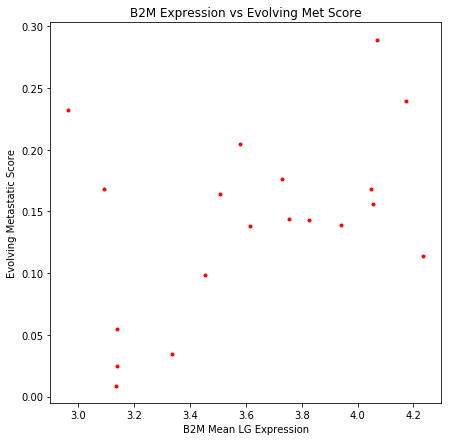

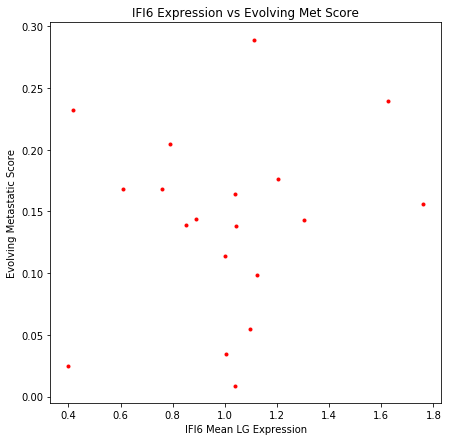

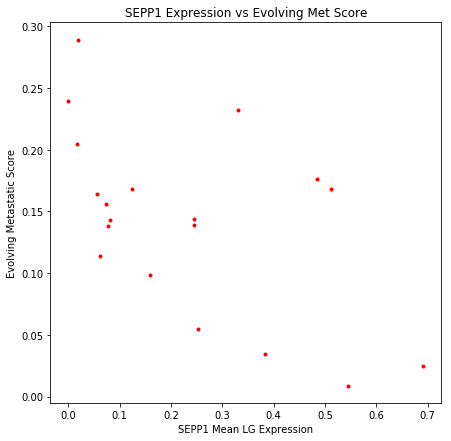

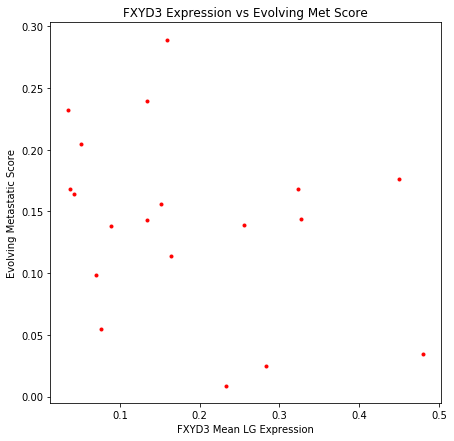

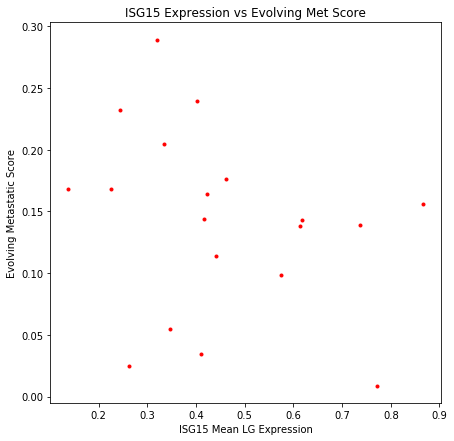

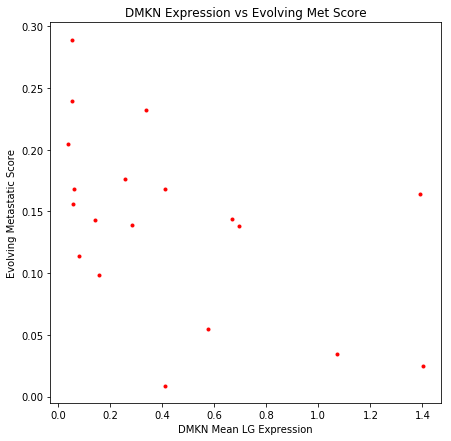

ZNF605


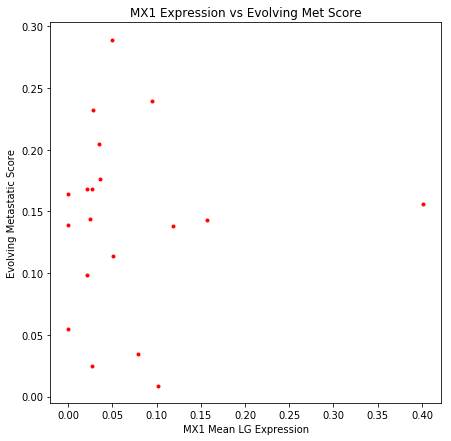

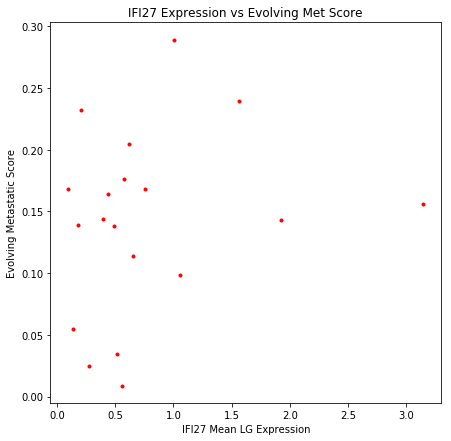

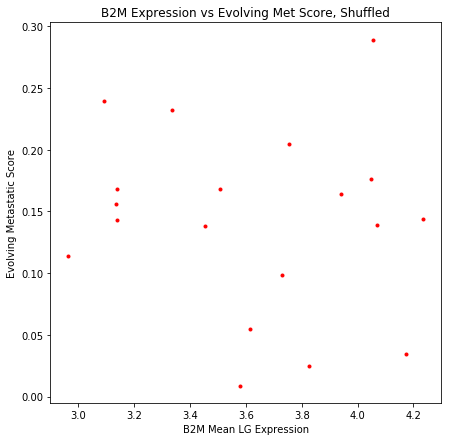

In [385]:
for gene in ["B2M", "IFI6", "SEPP1", "FXYD3", "ISG15", "DMKN", "ZNF605", "MX1", 'IFI27']:
    
    plt.close()
    
    if gene not in lg_adata.var_names:
        print(gene)
        continue
    
    h = plt.figure(figsize=(7,7))
    plt.plot(lg_adata.X[:,(lg_adata.var_names == gene)][:,0], lg_adata.obs["dynamic"], 'r.')
    plt.xlabel(gene + " Mean LG Expression")
    plt.ylabel("Evolving Metastatic Score")
    plt.title(gene + " Expression vs Evolving Met Score")
    plt.show()
    plt.savefig('figs/100k/' + gene + "_vs_evomet.100k.pdf")

evoarr = lg_adata.obs["dynamic"].values
evoarr = np.random.permutation(evoarr)
plt.close()
# plot shuffled gene list 
h = plt.figure(figsize=(7,7))
plt.plot(lg_adata.X[:,(lg_adata.var_names == "B2M")][:,0], evoarr, 'r.')
plt.xlabel("B2M Mean LG Expression")
plt.ylabel("Evolving Metastatic Score")
plt.title("B2M" + " Expression vs Evolving Met Score, Shuffled")
plt.show()